<a href="https://colab.research.google.com/github/labonibiswas/SepsisDetection/blob/main/TBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''1)load dataset'''
import pandas as pd
df = pd.read_csv('Dataset.csv')

patient_status = df.groupby('Patient_ID')['SepsisLabel'].max()

counts = patient_status.value_counts()
print("Total Patients in Original dataset:", len(patient_status))
print(f"Sepsis Negative (-) Patients in Original dataset: {counts.get(0, 0)}")
print(f"Sepsis Positive (+) Patients in Original dataset: {counts.get(1, 0)}")


Total Patients in Original dataset: 40336
Sepsis Negative (-) Patients in Original dataset: 37404
Sepsis Positive (+) Patients in Original dataset: 2932


In [ ]:
'''2)get all the 2932 sepsis patient and fill them, get all healthy patient with not null rows'''

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

cols = ['HR','O2Sat','Temp','SBP','DBP','Resp','Age','Gender','SepsisLabel','Patient_ID']
WINDOW_SIZE = 5

# --- STEP 1 ---

# 1. Get all Healthy IDs from original df
all_labels = df.groupby('Patient_ID')['SepsisLabel'].max()
healthy_ids = all_labels[all_labels == 0].index

# 2. Get their data
healthy_raw = df[df['Patient_ID'].isin(healthy_ids)][cols].copy()

# 3. Apply STRICT cleaning (Dropna)
healthy_clean = healthy_raw.dropna()

# 4. Filter: Must have at least 5 rows
healthy_clean = healthy_clean.groupby('Patient_ID').filter(lambda x: len(x) >= WINDOW_SIZE)

# 5. Take exactly top 5 rows
healthy_final = healthy_clean.groupby('Patient_ID').head(WINDOW_SIZE)
print(f"Healthy Patients count: {len(healthy_final['Patient_ID'].unique())}")
print("\n")

# --- STEP 2: PREPARE SEPSIS PATIENTS (Padding) ---
# 1. Get Sepsis IDs
sepsis_ids = all_labels[all_labels == 1].index
sepsis_raw = df[df['Patient_ID'].isin(sepsis_ids)][cols].copy()

# 2. Impute Missing Values (Fillna)
#    Forward Fill -> Backward Fill -> Global Mean
sepsis_filled = sepsis_raw.groupby('Patient_ID', group_keys=False).apply(lambda x: x.ffill().bfill())
sepsis_filled = sepsis_filled.fillna(sepsis_filled.mean())

# 3. Padding Function
def pad_patient_data(group):
    current_len = len(group)
    if current_len >= WINDOW_SIZE:
        return group.tail(WINDOW_SIZE) # Take most recent 5 hours
    else:
        # Pad with the first row repeated
        num_missing = WINDOW_SIZE - current_len
        padding = pd.concat([group.iloc[[0]]] * num_missing, ignore_index=True)
        return pd.concat([padding, group], ignore_index=True)

# 4. Apply Padding
sepsis_padded = sepsis_filled.groupby('Patient_ID', group_keys=False).apply(pad_patient_data)
print("\n")
print(f"Sepsis Patients count: {len(sepsis_padded['Patient_ID'].unique())}")


# --- STEP 3: SMOTE ---
# 1. Prepare Data for SMOTE (Flattening)
# We only want to oversample the SEPSIS group, but SMOTE usually balances classes.
# Strategy: We'll create a temporary X/y dataset of just unique patients
# Flatten: (Patients, 5 rows * 8 features) -> 1D vector per patient

# Extract features only (exclude ID and Label for SMOTE generation)
feature_cols = ['HR','O2Sat','Temp','SBP','DBP','Resp','Age','Gender']
n_features = len(feature_cols)

# A. Process Healthy (Keep as is)
X_healthy = []
for pid, group in healthy_final.groupby('Patient_ID'):
    X_healthy.append(group[feature_cols].values.flatten()) # Flatten 5x8 to 40
X_healthy = np.array(X_healthy)

# B. Process Sepsis (To be SMOTEd)
X_sepsis = []
for pid, group in sepsis_padded.groupby('Patient_ID'):
    X_sepsis.append(group[feature_cols].values.flatten())
X_sepsis = np.array(X_sepsis)

# 2. Calculate Target Counts
n_healthy = len(X_healthy)
# Goal: Sepsis = 35% of Total.
# Total = Healthy / 0.65
# Target Sepsis = Total * 0.35
n_total_target = int(n_healthy / 0.65)
n_sepsis_target = int(n_total_target * 0.35)

print("Appling SMOTE...")

# 3. Apply SMOTE
# We construct a dummy X and y to trick SMOTE into giving us the exact number we want
X_combined = np.vstack([X_healthy, X_sepsis])
y_combined = np.hstack([np.zeros(n_healthy), np.ones(len(X_sepsis))])

# sampling_strategy dict tells SMOTE exactly how many samples we want for class 1
smote = SMOTE(sampling_strategy={1: n_sepsis_target}, random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_combined, y_combined)

# 4. Reconstruct Dataframe (Un-Flatten)
# We need to turn the flat arrays back into the 5-row format for your TCN
# Get just the sepsis part (which now includes synthetic patients)
X_sepsis_new = X_resampled_flat[y_resampled == 1]

# Create a list to hold the new rows
new_rows = []
start_id = 900000 # Fake IDs for synthetic patients

for i, flat_patient in enumerate(X_sepsis_new):
    # Reshape (40,) -> (5, 8)
    patient_matrix = flat_patient.reshape(WINDOW_SIZE, n_features)

    # Create DataFrame for this patient
    pat_df = pd.DataFrame(patient_matrix, columns=feature_cols)
    pat_df['Patient_ID'] = start_id + i
    pat_df['SepsisLabel'] = 1
    new_rows.append(pat_df)

sepsis_final_df = pd.concat(new_rows, ignore_index=True)

# Combine with original Healthy data
# (Ensure columns match)
healthy_final['Patient_ID'] = healthy_final['Patient_ID'].astype(int) # Ensure IDs match type
final_dataset = pd.concat([healthy_final, sepsis_final_df], ignore_index=True)

# --- FINAL REPORT ---
print("-" * 30)
print("FINAL DATASET REPORT")
counts = final_dataset.groupby('Patient_ID')['SepsisLabel'].max().value_counts()
n_h = counts.get(0, 0)
n_s = counts.get(1, 0)
total = n_h + n_s
print(f"Healthy Patients: {n_h} ({n_h/total:.1%})")
print(f"Sepsis Patients:  {n_s} ({n_s/total:.1%})")
print(f"Total Rows:       {len(final_dataset)}")
print(f"Total patient:       {len(final_dataset) / 5}")

Healthy Patients count: 24435




/tmp/ipython-input-2476595579.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sepsis_filled = sepsis_raw.groupby('Patient_ID', group_keys=False).apply(lambda x: x.ffill().bfill())
/tmp/ipython-input-2476595579.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sepsis_padded = sepsis_filled.groupby('Patient_ID', group_keys=False).apply(pad_patient_data)




Sepsis Patients count: 2932
Appling SMOTE...
------------------------------
FINAL DATASET REPORT
Healthy Patients: 24435 (65.0%)
Sepsis Patients:  13157 (35.0%)
Total Rows:       187960
Total patient:       37592.0


/tmp/ipython-input-2476595579.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy_final['Patient_ID'] = healthy_final['Patient_ID'].astype(int) # Ensure IDs match type


In [ ]:
'''3)splitting and scaling for new final_dataset(split data training and testing)'''


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- CONFIGURATION ---
# We exclude 'SepsisLabel' and 'Patient_ID' from the input features
feature_cols = ['HR','O2Sat','Temp','SBP','DBP','Resp','Age','Gender']
target_col = 'SepsisLabel'
WINDOW_SIZE = 5

print("Starting Data Preparation...")

# 1. SPLIT BY PATIENT ID (Crucial for Medical AI)
# We split the IDs, not the rows, to ensure no data leakage.
unique_ids = final_dataset['Patient_ID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

print(f"Total Patients: {len(unique_ids)}")
print(f"Training Patients: {len(train_ids)}")
print(f"Testing Patients:  {len(test_ids)}")

# Create the dataframes
train_df = final_dataset[final_dataset['Patient_ID'].isin(train_ids)].copy()
test_df = final_dataset[final_dataset['Patient_ID'].isin(test_ids)].copy()

# 2. SCALE THE DATA (StandardScaler)
# fit_transform on TRAIN, transform on TEST (Prevent leakage)
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

print("Data Scaled successfully.")

# 3. RESHAPE TO 3D (Patients, TimeSteps, Features)
def create_3d_dataset(dataframe):
    X, y = [], []
    # Since we padded everyone to exactly 5 rows, we can simply group and extract
    for pid, group in dataframe.groupby('Patient_ID'):
        X.append(group[feature_cols].values)
        y.append(group[target_col].max()) # 1 if Sepsis, 0 if Healthy
    return np.array(X), np.array(y)

print("Reshaping to 3D...")
X_train, y_train = create_3d_dataset(train_df)
X_test, y_test = create_3d_dataset(test_df)

print("-" * 30)
print(f"Training Data Shape: {X_train.shape}  (Patients, 5 Hours, 8 vitals)")
print(f"Testing Data Shape:  {X_test.shape} (Patients, 5 Hours, 8 vitals)")
print("-" * 30)

Starting Data Preparation...
Total Patients: 37592
Training Patients: 26314
Testing Patients:  11278
Data Scaled successfully.
Reshaping to 3D...
------------------------------
Training Data Shape: (26314, 5, 8)  (Patients, 5 Hours, 8 vitals)
Testing Data Shape:  (11278, 5, 8) (Patients, 5 Hours, 8 vitals)
------------------------------


In [ ]:
'''4)TBC Layer'''

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv1D, Concatenate

class TiedBlockConv1D(Layer):
    def __init__(self, filters, kernel_size, blocks=2, padding='causal', dilation_rate=1, activation='relu', **kwargs):
        super(TiedBlockConv1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.blocks = blocks
        self.padding = padding
        self.dilation_rate = dilation_rate
        self.activation = activation

        # The "Shared" Filter (This is the magic that saves memory)
        self.shared_conv = Conv1D(
            filters=filters // blocks,
            kernel_size=kernel_size,
            padding=padding,
            dilation_rate=dilation_rate,
            activation=activation
        )

    def call(self, inputs):
        # 1. Split features into blocks
        block_inputs = tf.split(inputs, num_or_size_splits=self.blocks, axis=2)
        # 2. Apply the SAME filter to every block
        block_outputs = [self.shared_conv(b) for b in block_inputs]
        # 3. Recombine
        return Concatenate(axis=2)(block_outputs)

    def get_config(self):
        config = super(TiedBlockConv1D, self).get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "blocks": self.blocks,
            "padding": self.padding,
            "dilation_rate": self.dilation_rate,
            "activation": self.activation
        })
        return config

print("✅ TBC Layer Ready.")

✅ TBC Layer Ready.


In [ ]:
'''5)Building TBC Model'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling1D, Input
from tensorflow.keras.optimizers import Adam

BEST_FILTERS = 48      # SepAl used 64. Using 48 makes us lighter.
BEST_KERNEL = 3        # Kernel 3 captures slightly longer patterns than 2.
BEST_DROPOUT = 0.4     # High dropout prevents overfitting on synthetic SMOTE data.
BEST_LR = 1e-3         # Standard learning rate.

print("Building TBC Model...")

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), # (5 hours, 8 features)

    # Layer 1: TBC (Captures immediate vitals changes)
    TiedBlockConv1D(
        filters=BEST_FILTERS,
        kernel_size=BEST_KERNEL,
        blocks=2,             # Split 8 features into 2 blocks of 4
        padding='causal',
        activation='relu',
        dilation_rate=1
    ),
    Dropout(BEST_DROPOUT),

    # Layer 2: TBC (Captures trends over the full 5 hours)
    TiedBlockConv1D(
        filters=BEST_FILTERS,  # Keep filters consistent
        kernel_size=BEST_KERNEL,
        blocks=2,
        padding='causal',
        activation='relu',
        dilation_rate=2       # Dilation lets us see history
    ),
    Dropout(BEST_DROPOUT),

    # Summarize & Output
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=BEST_LR),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])


model.summary()

Building TBC Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tied_block_conv1d               │ (None, 5, 48)          │           312 │
│ (TiedBlockConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 48)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tied_block_conv1d_1             │ (None, 5, 48)          │         1,752 │
│ (TiedBlockConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 48)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 48)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113 (8.25 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
'''6) TBC Model Training'''

from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

# --- 1. Calculate Class Weights ---
# This forces the model to pay extra attention to the minority class (Sepsis)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Convert to dictionary format for Keras
weight_dict = dict(enumerate(class_weights))

print(f" Calculated Class Weights: {weight_dict}")

# --- 2. Train with Weights ---
print("Starting Training...")
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight=weight_dict,  # <--- THIS IS THE KEY CHANGE
    verbose=1
)


# --- 3. Smart Evaluation (Threshold Tuning) ---
print("\nCalculating Optimization Metrics...")
y_pred_prob = model.predict(X_test).ravel()

# Find the threshold that maximizes Sensitivity + Specificity
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print(f"🔎 Optimization Found: Best Decision Threshold = {best_thresh:.4f}")

# Apply the Optimized Threshold
y_pred = (y_pred_prob > best_thresh).astype(int)

# --- 4. The Scorecard ---
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
roc_auc = auc(fpr, tpr)

print("\n" + "-"*40)
print(f"✅ Accuracy:    {accuracy*100:.2f}%")
print(f"✅ AUC Score:   {roc_auc:.4f}")
print(f"✅ Sensitivity: {sensitivity*100:.2f}% (Recall)")
print(f"✅ Specificity: {specificity*100:.2f}%")
print("-" * 40)
print(f"Sepsis Patients Correctly Found: {tp}")
print(f"Sepsis Patients Missed:          {fn}")

 Calculated Class Weights: {0: np.float64(0.7718526340490438), 1: np.float64(1.4196158826068193)}
Starting Training...
Epoch 1/60
412/412 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6620 - auc: 0.7068 - loss: 0.6256 - val_accuracy: 0.7481 - val_auc: 0.8233 - val_loss: 0.5531
Epoch 2/60
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7472 - auc: 0.8078 - loss: 0.5416 - val_accuracy: 0.7910 - val_auc: 0.8682 - val_loss: 0.5044
Epoch 3/60
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7712 - auc: 0.8368 - loss: 0.5052 - val_accuracy: 0.8101 - val_auc: 0.8880 - val_loss: 0.4699
Epoch 4/60
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7939 - auc: 0.8654 - loss: 0.4647 - val_accuracy: 0.8269 - val_auc: 0.9097 - val_loss: 0.4449
Epoch 5/60
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8059 - auc: 0.8832 - loss: 0.4358 - val_accuracy: 0.8323 - val_auc: 0.9249 - val_loss: 0.4309
Epoch 6/60
412/412 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8155 - auc: 0.

Predicting on Test Data...
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


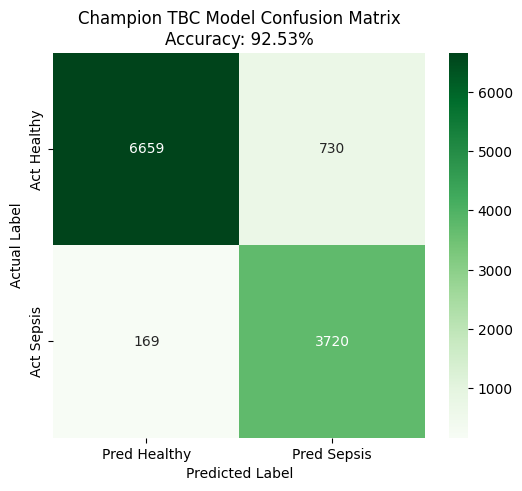


--- Detailed Report ---
              precision    recall  f1-score   support

     Healthy       0.98      0.90      0.94      7389
      Sepsis       0.84      0.96      0.89      3889

    accuracy                           0.92     11278
   macro avg       0.91      0.93      0.91     11278
weighted avg       0.93      0.92      0.92     11278


SAFETY CHECK:
 Sepsis Patients Correctly Found: 3720
 Sepsis Patients Missed:          169
 Recall (Sensitivity):            95.65%


In [ ]:
'''Confusion Matrix'''
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get Predictions from TBC Model
print("Predicting on Test Data...")
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 2. Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Visualise it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Healthy', 'Pred Sepsis'],
            yticklabels=['Act Healthy', 'Act Sepsis'])
plt.title(f'Champion TBC Model Confusion Matrix\nAccuracy: {92.53:.2f}%') # Adjust title based on your previous output
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Print the numbers clearly
print("\n--- Detailed Report ---")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Sepsis']))

# 5. Medical Safety Check
tn, fp, fn, tp = cm.ravel()
print(f"\nSAFETY CHECK:")
print(f" Sepsis Patients Correctly Found: {tp}")
print(f" Sepsis Patients Missed:          {fn}")
print(f" Recall (Sensitivity):            {tp / (tp + fn):.2%}")


In [ ]:
'''K fold cross velidation'''
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# --- 1. PREPARE DATA FOR CV ---
# We merge the existing Train/Test split back together to get the full dataset
X_full = np.concatenate([X_train, X_test], axis=0)
y_full = np.concatenate([y_train, y_test], axis=0)

print(f"Starting 10-Fold Cross Validation on {len(X_full)} samples...")

# --- 2. CONFIGURATION ---
FOLDS = 10
EPOCHS = 40        # Slightly reduced epochs to save time (since we run it 10x)
BATCH_SIZE = 64
kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Lists to store results
acc_scores = []
auc_scores = []
sens_scores = []
spec_scores = []

# --- 3. THE CROSS-VALIDATION LOOP ---
fold_no = 1
for train_index, val_index in kfold.split(X_full, y_full):
    print(f"\n🔄 Running Fold {fold_no} / {FOLDS}...")

    # A. Split Data for this Fold
    X_train_fold, X_val_fold = X_full[train_index], X_full[val_index]
    y_train_fold, y_val_fold = y_full[train_index], y_full[val_index]

    # B. Calculate Weights for this specific fold (Important for imbalance/35:65)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_fold),
        y=y_train_fold
    )
    weight_dict = dict(enumerate(class_weights))

    # C. Re-Build a FRESH Model (Clear previous memory)
    tf.keras.backend.clear_session()

    model_cv = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),

        # Layer 1
        TiedBlockConv1D(filters=48, kernel_size=3, blocks=2, padding='causal', activation='relu', dilation_rate=1),
        Dropout(0.4),

        # Layer 2
        TiedBlockConv1D(filters=48, kernel_size=3, blocks=2, padding='causal', activation='relu', dilation_rate=2),
        Dropout(0.4),

        GlobalMaxPooling1D(),
        Dense(1, activation='sigmoid')
    ])

    model_cv.compile(optimizer=Adam(learning_rate=1e-3),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

    # D. Train
    # We turn verbose=0 to keep the output clean (no progress bar spam)
    model_cv.fit(X_train_fold, y_train_fold,
                 epochs=EPOCHS,
                 batch_size=BATCH_SIZE,
                 class_weight=weight_dict,
                 verbose=0)

    # E. Evaluate
    y_pred_prob = model_cv.predict(X_val_fold, verbose=0).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate Metrics
    acc = accuracy_score(y_val_fold, y_pred)
    auc = roc_auc_score(y_val_fold, y_pred_prob)

    tn, fp, fn, tp = confusion_matrix(y_val_fold, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    print(f"   > Accuracy: {acc*100:.2f}% | AUC: {auc:.4f} | Recall: {sensitivity*100:.2f}%")

    acc_scores.append(acc)
    auc_scores.append(auc)
    sens_scores.append(sensitivity)
    spec_scores.append(specificity)

    fold_no += 1

# --- 4. FINAL REPORT ---
print("\n" + "="*40)
print("🏆 10-FOLD CROSS VALIDATION RESULTS")
print("="*40)
print(f"✅ Average Accuracy:    {np.mean(acc_scores)*100:.2f}% (+/- {np.std(acc_scores)*100:.2f}%)")
print(f"✅ Average AUC Score:   {np.mean(auc_scores):.4f}")
print(f"✅ Average Sensitivity: {np.mean(sens_scores)*100:.2f}% (Recall)")
print(f"✅ Average Specificity: {np.mean(spec_scores)*100:.2f}%")
print("-" * 40)


Starting 10-Fold Cross Validation on 37592 samples...

🔄 Running Fold 1 / 10...
   > Accuracy: 90.27% | AUC: 0.9812 | Recall: 96.88%

🔄 Running Fold 2 / 10...
   > Accuracy: 92.82% | AUC: 0.9797 | Recall: 93.47%

🔄 Running Fold 3 / 10...
   > Accuracy: 90.45% | AUC: 0.9762 | Recall: 96.27%

🔄 Running Fold 4 / 10...
   > Accuracy: 88.16% | AUC: 0.9747 | Recall: 97.11%

🔄 Running Fold 5 / 10...
   > Accuracy: 90.66% | AUC: 0.9805 | Recall: 96.65%

🔄 Running Fold 6 / 10...
   > Accuracy: 89.23% | AUC: 0.9699 | Recall: 95.06%

🔄 Running Fold 7 / 10...
   > Accuracy: 92.79% | AUC: 0.9808 | Recall: 93.24%

🔄 Running Fold 8 / 10...
   > Accuracy: 89.70% | AUC: 0.9767 | Recall: 97.26%

🔄 Running Fold 9 / 10...
   > Accuracy: 94.01% | AUC: 0.9840 | Recall: 93.69%

🔄 Running Fold 10 / 10...
   > Accuracy: 92.18% | AUC: 0.9724 | Recall: 89.13%

🏆 10-FOLD CROSS VALIDATION RESULTS
✅ Average Accuracy:    91.03% (+/- 1.76%)
✅ Average AUC Score:   0.9776
✅ Average Sensitivity: 94.88% (Recall)
✅ Averag